# Word Embedding - Home Assigment
## Dr. Omri Allouche 2021-2022. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/ydata_deep_learning_2021/blob/master/assignments/word_vectors_text_classification/DL_word_embedding_assignment.ipynb)

    
In this exercise, you'll use word vectors trained on a corpus of lyrics of songs from MetroLyrics http://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet.
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

## import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import operator
import itertools

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer

from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

pd.set_option('max_colwidth', 256)



## load the dataset

In [2]:
parquet_file = 'https://github.com/omriallouche/ydata_deep_learning_2021/blob/master/data/metrolyrics.parquet?raw=true'
data = pd.read_parquet(parquet_file, engine='auto')
data.head()

,song,year,artist,genre,lyrics,num_chars,sent,num_words
204182,fully-dressed,2008,annie,Pop,"[HEALY]\n[spoken] This is Bert Healy saying ...\n[singing now] Hey, hobo man\nHey, Dapper Dan\nYou've both got your style\nBut Brother,\nYou're never fully dressed\nWithout a smile!\nYour clothes may be Beau Brummelly\nThey stand out a mile --\nBut Bro...",1041,healy spoken this bert healy saying singing hey hobo man hey dapper dan you got style but brother you never fully dressed without smile your clothes may beau brummelly they stand mile but brother you never fully dressed without smile who cares wearing ...,826
6116,surrounded-by-hoes,2006,50-cent,Hip-Hop,"[Chorus: repeat 2X] Even when I'm tryin to be on the low, I'm recognized by hoes Cause the game sure wasn't like this before, it wasn't like this before Everywhere I'm at everywhere I go, I stay surrounded by hoes Man, its gotta be cause of the dough, ...",1392,chorus repeat x even i tryin low i recognized hoes cause game sure like like everywhere i everywhere i go i stay surrounded hoes man got ta cause dough got cause dough verse one cent i makin hits don try act like heard i shit you see react i come door ...,884
166369,taste-the-tears-thunderpuss-remix,2006,amber,Pop,How could you cause me so much pain?\nAnd leave my Heart out in the rain\nAfter I gave you everything oh oh\nWhy did you have to tell me lies?\nAnd put these tears here in my eyes\nAnd push my world with your good-bye oh oh\nYou think that you're immun...,1113,how could cause much pain and leave heart rain after i gave everything oh oh why tell lies and put tears eyes and push world good bye oh oh you think immune but someday baby someday soon you gon na taste tears tears i cried right you going taste you go...,756
198416,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come to my decision\nOn a dog day afternoon\nI'm breaking my tradition\nI think I realize\nI walk on gilded splinters\nI have shaken my disguise\nI'm not looking for confrontation\nI'm not looking for sympathy\n...,779,in scarlet vision in velvet room i come decision on dog day afternoon i breaking tradition i think i realize i walk gilded splinters i shaken disguise i looking confrontation i looking sympathy i looking aggravation the truth set free i need somebody p...,583
127800,the-last-goodbye,2008,aaron-pritchett,Country,"Sprintime in Savannah\nIt dont get much prettier than this\nBut it feels like its wintertime to me\nThe sky is clear and the sun is bright\nI aint looking forward to the night\nCuz a cold chill is all Im gonna feel\nIm so sorry, I know the fault is min...",881,sprintime savannah it dont get much prettier but feels like wintertime the sky clear sun bright i aint looking forward night cuz cold chill im gon na feel im sorry i know fault mine i guess theres nothing left try as pack bags i deny this last goodbye ...,639


### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

## clean the dataset songs

In [3]:
from functools import lru_cache
import nltk
import re
import string 

stopwords = nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))


@lru_cache(maxsize=512)
def word_processing(word):
  # lower case, remove redundant spaces
  word = word.strip().lower()
  #remove punctuation
  word = word.translate(str.maketrans('', '', string.punctuation))
  # remove stop words
  if word in stopwords:
    return ''
  return word

def song_processing(song):
  # remove words that are between []
  song = re.sub(r'\[\w+\]', '', song)
  new_words = []
  for w in song.split():
    new_w = word_processing(w)
    if len(new_w) > 1:
      new_words.append(new_w)
  clean_text = ' '.join(new_words)
  return clean_text


data['clean_text'] = data['lyrics'].apply(lambda x: song_processing(x))
data['clean_text'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


204182    bert healy saying singing hey hobo man hey dapper dan youve got style brother youre never fully dressed without smile clothes may beau brummelly stand mile brother youre never fully dressed without smile cares theyre wearing main street saville row wea...
6116      chorus repeat 2x even im tryin low im recognized hoes cause game sure wasnt like wasnt like everywhere im everywhere go stay surrounded hoes man gotta cause dough got cause dough verse one 50 cent im makin hits dont try act like aint heard im shit see ...
166369    could cause much pain leave heart rain gave everything oh oh tell lies put tears eyes push world goodbye oh oh think youre immune someday baby someday soon youre gonna taste tears tears cried right youre going taste youre going taste youre going taste ...
198416    scarlet vision velvet room come decision dog day afternoon im breaking tradition think realize walk gilded splinters shaken disguise im looking confrontation im looking sympathy im looking agg

In [4]:
from collections import Counter, OrderedDict

document_frequency_counter = Counter()
high_frequency_words = []

# count song frequency for each word
for index, doc in data.iterrows():
  unique_words = set(doc['clean_text'].split())
  document_frequency_counter.update(unique_words)

# keep only words that appear in at least 20
for word, count in dict(document_frequency_counter).items():
  if count >= 20:
    high_frequency_words.append(word)

# remove words that are not high frequency
def keep_words_by_given_list(words, keeping_words):
  return ' '.join([w for w in words if w in keeping_words])

data['clean_text'] = data['clean_text'].apply(lambda x: keep_words_by_given_list(x.split(), high_frequency_words))
data['bag_of_words'] = data['clean_text'].apply(lambda x: x.split())

# remove songs without words
data = data[data['bag_of_words'].map(lambda d: len(d)) > 0]


### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

## train word2vec model

In [5]:
from gensim.models import Word2Vec

def get_most_similar_words(model, word, topn=5):
  word_vector = model.wv[word]
  sims = model.wv.most_similar(word, topn=topn)
  return sims

model = Word2Vec(sentences=data['bag_of_words'], vector_size=300, window=5, min_count=10, workers=4)

## similar words

In [6]:
intersting_words = ['hate', 'baby', 'california',  'moon', 'cadillac']

for word in intersting_words:
  similar_words = get_most_similar_words(model, word)
  print(f"The most similar words for the word {word} are {similar_words}")

The most similar words for the word hate are [('hating', 0.4632006883621216), ('jealousy', 0.4454311430454254), ('envy', 0.4296780824661255), ('haters', 0.39392542839050293), ('fake', 0.39147746562957764)]
The most similar words for the word baby are [('girl', 0.6388806700706482), ('babe', 0.6298723816871643), ('love', 0.5783380270004272), ('oh', 0.5151288509368896), ('darlin', 0.5102137923240662)]
The most similar words for the word california are [('florida', 0.650001049041748), ('arizona', 0.6447938680648804), ('tennessee', 0.6359948515892029), ('texas', 0.6323721408843994), ('memphis', 0.631422221660614)]
The most similar words for the word moon are [('stars', 0.6442487835884094), ('shines', 0.6069326996803284), ('moonlight', 0.604931116104126), ('sunlight', 0.6042205691337585), ('starlight', 0.5976229310035706)]
The most similar words for the word cadillac are [('impala', 0.7600792050361633), ('lac', 0.7481656074523926), ('benz', 0.7404536604881287), ('bentley', 0.7392382621765137

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [7]:
def most_similar_words_by_vector(model, positives, negatives, distance_metric ,revearse=True, topn=5):
  # get the vector of the words
  vector = np.zeros(model.wv.vector_size, dtype=np.float32)
  for word in positives:
    vector +=model.wv[word]
  for word in negatives:
    vector -=model.wv[word]
  # calculate similarity to the vector
  words_similarity = {}
  vector = vector.reshape(1,-1)
  for word in model.wv.index_to_key:
    word_vector = model.wv[word].reshape(1, -1)
    similarity = distance_metric(vector, word_vector)
    words_similarity[word] = similarity[0][0]
  # reverse because for cosine we want high value, eculidian we want lowest value
  words_similarity = dict(sorted(words_similarity.items(), key=operator.itemgetter(1),reverse=revearse))
  top_similarity = dict(itertools.islice(words_similarity.items(), topn))

  return top_similarity

# euclidean_distances similarity
print(f"Positivies: [girl], Negative: [man], most similar: {most_similar_words_by_vector(model, ['girl'], ['man'], euclidean_distances ,revearse=False, topn=5)}")
print(f"Positivies: [liar], Negative: [honest], most similar: {most_similar_words_by_vector(model, ['liar'], ['honest'], euclidean_distances ,revearse=False, topn=5)}")
print(f"Positivies: [funny, charm], Negative: [anger], most similar: {most_similar_words_by_vector(model, ['funny', 'charm'], ['anger'], euclidean_distances ,revearse=False, topn=5)}")
print(f"Positivies: [money, cadillac], Negative: [loser], most similar: {most_similar_words_by_vector(model, ['money', 'cadillac'], ['loser'], euclidean_distances ,revearse=False, topn=5)}")


Positivies: [girl], Negative: [man], most similar: {'girl': 12.116916, 'shy': 15.715864, 'freaky': 15.757804, 'kissin': 15.846385, 'kisses': 15.878723}
Positivies: [liar], Negative: [honest], most similar: {'liar': 6.841847, 'barbed': 9.187885, 'choked': 9.380193, 'moth': 9.400103, 'spiders': 9.434618}
Positivies: [funny, charm], Negative: [anger], most similar: {'funny': 9.911951, 'cute': 13.905132, 'laughin': 14.634006, 'kinda': 14.792763, 'silly': 15.0768}
Positivies: [money, cadillac], Negative: [loser], most similar: {'money': 9.685391, 'stack': 14.736081, 'cash': 14.849047, 'stacks': 14.904735, 'bank': 14.964781}


In [8]:
# cosine distance
print(f"Positivies: [girl], Negative: [man], most similar: {most_similar_words_by_vector(model, ['girl'], ['man'], cosine_similarity ,revearse=True, topn=5)}")
print(f"Positivies: [liar], Negative: [honest], most similar: {most_similar_words_by_vector(model, ['liar'], ['honest'], cosine_similarity ,revearse=True, topn=5)}")
print(f"Positivies: [funny, charm], Negative: [anger], most similar: {most_similar_words_by_vector(model, ['funny', 'charm'], ['anger'], cosine_similarity ,revearse=True, topn=5)}")
print(f"Positivies: [money, cadillac], Negative: [loser], most similar: {most_similar_words_by_vector(model, ['money', 'cadillac'], ['loser'], cosine_similarity ,revearse=True, topn=5)}")


Positivies: [girl], Negative: [man], most similar: {'girl': 0.7054293, 'baby': 0.45084566, 'sexy': 0.38123432, 'babe': 0.36231115, 'freaky': 0.35745144}
Positivies: [liar], Negative: [honest], most similar: {'liar': 0.7573201, 'wire': 0.39450395, 'barbed': 0.39038485, 'flames': 0.38284683, 'burns': 0.37758476}
Positivies: [funny, charm], Negative: [anger], most similar: {'funny': 0.80517924, 'cute': 0.55184144, 'laughin': 0.5158758, 'kinda': 0.4821851, 'honey': 0.4486382}
Positivies: [money, cadillac], Negative: [loser], most similar: {'money': 0.8590742, 'stack': 0.63826865, 'stacks': 0.63496006, 'cash': 0.6146214, 'bank': 0.6130879}


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a regressor to predict the sentiment score of a word given its word vector (the vector you computed using the song lyrics dataset), in range -1 to 1. Split the data to a train and test sets, and report the model performance on both sets.

In [9]:
!curl https://saifmohammad.com/WebDocs/lexiconstoreleaseonsclpage/SemEval2015-English-Twitter-Lexicon.zip -o SemEval2015-English-Twitter-Lexicon.zip
!unzip  SemEval2015-English-Twitter-Lexicon.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10250  100 10250    0     0  18336      0 --:--:-- --:--:-- --:--:-- 18303
Archive:  SemEval2015-English-Twitter-Lexicon.zip
   creating: SemEval2015-English-Twitter-Lexicon/
  inflating: SemEval2015-English-Twitter-Lexicon/readme.txt  
  inflating: SemEval2015-English-Twitter-Lexicon/SemEval2015-English-negators.txt  
  inflating: SemEval2015-English-Twitter-Lexicon/SemEval2015-English-Twitter-Lexicon.txt  


In [10]:
with open('/content/SemEval2015-English-Twitter-Lexicon/SemEval2015-English-Twitter-Lexicon.txt', 'r') as file_reader:
  file_content = file_reader.readlines()

word_sentiment = {}
for line in file_content:
  score, word = line.split('\t')
  score = float(score)
  word = word.strip().replace('\n', '')
  word = word.replace('#', '')
  word_sentiment[word] = score


In [11]:
relevant_words_sentiment_analysis = {}
relevant_words_vectors = {}

for word in word_sentiment.keys():
  if word in model.wv.index_to_key:
    relevant_words_sentiment_analysis[word] = word_sentiment[word]
    relevant_words_vectors[word] = model.wv[word]


relevant_words_vectors = pd.DataFrame(relevant_words_vectors)
relevant_words_sentiment_analysis = pd.Series(relevant_words_sentiment_analysis)
print(f"Number of words in vocabulary {len(relevant_words_sentiment_analysis)}")

Number of words in vocabulary 778


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [12]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

train_x, test_x, train_y, test_y = train_test_split(relevant_words_vectors.T, relevant_words_sentiment_analysis)

svr_model = SVR()
svr_model.fit(train_x, train_y)

sentiment_analysis_test_predictions = svr_model.predict(test_x)
sentiment_analysis_train_predictions = svr_model.predict(train_x)

train_error = mean_absolute_error(train_y, sentiment_analysis_train_predictions)
test_error = mean_absolute_error(test_y, sentiment_analysis_test_predictions)

print(f"Train MAE: {train_error}")
print(f"Test MAE: {test_error}")

Train MAE: 0.1778824142552226
Test MAE: 0.3037543577208926


In [13]:
tests_words = pd.DataFrame({'words': test_x.index, 'predicted_sentiment': sentiment_analysis_test_predictions})
tests_words.sort_values(by='predicted_sentiment', inplace=True)

tests_words
print(f"Top 10 Negative sentiment {tests_words['words'].iloc[0:10].values} \n")
print(f"Top 10 Positive sentiment {tests_words['words'].iloc[-10:].values} \n")

Top 10 Negative sentiment ['bastard' 'heartless' 'rotten' 'useless' 'bored' 'confused' 'sucking'
 'horror' 'fucking' 'hopeless'] 

Top 10 Positive sentiment ['heh' 'focused' 'lots' 'thanks' 'wonderful' 'rare' 'yep' 'whoo' 'lovely'
 'amazing'] 



### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. You are encouraged to try that color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [14]:

# keep only most 3000 words
most_common_words = document_frequency_counter.most_common(3000)
data['high_frequency_words'] = data['bag_of_words'].apply(lambda x: keep_words_by_given_list(x, dict(most_common_words).keys()).split())
most_common_words_genre = data.loc[:, ['genre', 'high_frequency_words']]

# convert list of words to binary columns
mlb = MultiLabelBinarizer()
df_transformed = pd.DataFrame(mlb.fit_transform(most_common_words_genre['high_frequency_words']), columns=mlb.classes_)
most_common_words_genre = pd.concat([most_common_words_genre['genre'], df_transformed], axis=1).dropna(axis=0)

# calculate words propotion by genre
words_propotion_by_genre = {}
for genre in most_common_words_genre['genre'].unique():

  genre_data = most_common_words_genre[most_common_words_genre['genre'] == genre].drop(['genre'], axis=1)
  genre_data = genre_data.sum(axis=0) / most_common_words_genre.sum(axis=0)
  words_propotion_by_genre[genre] = genre_data

words_propotion_by_genre = pd.DataFrame(words_propotion_by_genre, dtype=float)
words_propotion_by_genre

,Hip-Hop,Pop,Country,Metal,Rock
10,0.186813,0.164835,0.219780,0.252747,0.175824
100,0.227273,0.227273,0.151515,0.166667,0.227273
12,0.293103,0.275862,0.103448,0.137931,0.189655
20,0.238806,0.223881,0.238806,0.194030,0.104478
2x,0.194690,0.185841,0.212389,0.176991,0.230088
...,...,...,...,...,...
youve,0.197098,0.195889,0.216445,0.162031,0.228537
zeit,0.155556,0.244444,0.244444,0.222222,0.133333
zero,0.218750,0.218750,0.156250,0.218750,0.187500
zone,0.244186,0.186047,0.116279,0.244186,0.209302


In [15]:
# select top 50 words by genre 
top_50_by_genre = words_propotion_by_genre.apply(lambda x: x.nlargest(50), axis=0)
top_significant_words = list(top_50_by_genre.index)
top_significant_words



['accept',
 'adore',
 'ak',
 'allow',
 'alma',
 'anger',
 'aside',
 'astray',
 'automatic',
 'aware',
 'backs',
 'beam',
 'behold',
 'bent',
 'benz',
 'beware',
 'biggest',
 'blunts',
 'bob',
 'bother',
 'breed',
 'brick',
 'bridges',
 'button',
 'cadillac',
 'california',
 'cap',
 'caused',
 'cest',
 'charge',
 'charm',
 'chop',
 'cigarette',
 'clap',
 'clips',
 'cocaine',
 'comfort',
 'common',
 'complain',
 'constant',
 'coupe',
 'crashing',
 'crown',
 'crushed',
 'curse',
 'cute',
 'dat',
 'daylight',
 'decided',
 'decision',
 'deck',
 'deliver',
 'demon',
 'difference',
 'disrespect',
 'diss',
 'doe',
 'dove',
 'downtown',
 'dreamed',
 'drift',
 'drifting',
 'eagle',
 'eating',
 'ecstasy',
 'eine',
 'emotion',
 'ended',
 'english',
 'especially',
 'essence',
 'explode',
 'fan',
 'fancy',
 'favor',
 'feast',
 'fed',
 'feeding',
 'fields',
 'figured',
 'fin',
 'float',
 'floating',
 'flowing',
 'fore',
 'fue',
 'funk',
 'funky',
 'gaze',
 'generation',
 'glance',
 'goddamn',
 'grabb

In [16]:
top_50_by_genre

,Hip-Hop,Pop,Country,Metal,Rock
accept,NaN,0.320000,NaN,NaN,NaN
adore,NaN,NaN,NaN,NaN,0.323529
ak,NaN,NaN,0.315789,NaN,NaN
allow,NaN,NaN,0.333333,NaN,NaN
alma,NaN,0.323529,NaN,NaN,NaN
...,...,...,...,...,...
yard,0.344262,NaN,NaN,NaN,NaN
ye,NaN,NaN,NaN,0.361111,NaN
yell,NaN,NaN,0.343750,NaN,NaN
younger,NaN,0.342105,NaN,NaN,NaN


In [17]:
# get words vectors
top_significant_words_vectors = []
top_significant_words_genre = []

for word in top_significant_words:
  word_vector = model.wv[word]
  top_significant_words_vectors.append(word_vector)
  word_genres = top_50_by_genre.loc[word].dropna()
  if len(word_genres) == 1:
    top_significant_words_genre.append(word_genres.index[0])
  else:
    top_significant_words_genre.append('Nulti-Genre')

# compress vector using TSNE
commpress_vector = TSNE().fit_transform(np.array(top_significant_words_vectors))

# visualize words

commpress_vector = pd.DataFrame({'Word': top_significant_words, 
                                 'X': commpress_vector[:, 0],
                                 'Y': commpress_vector[:, 1],
                                 'Genre': top_significant_words_genre})

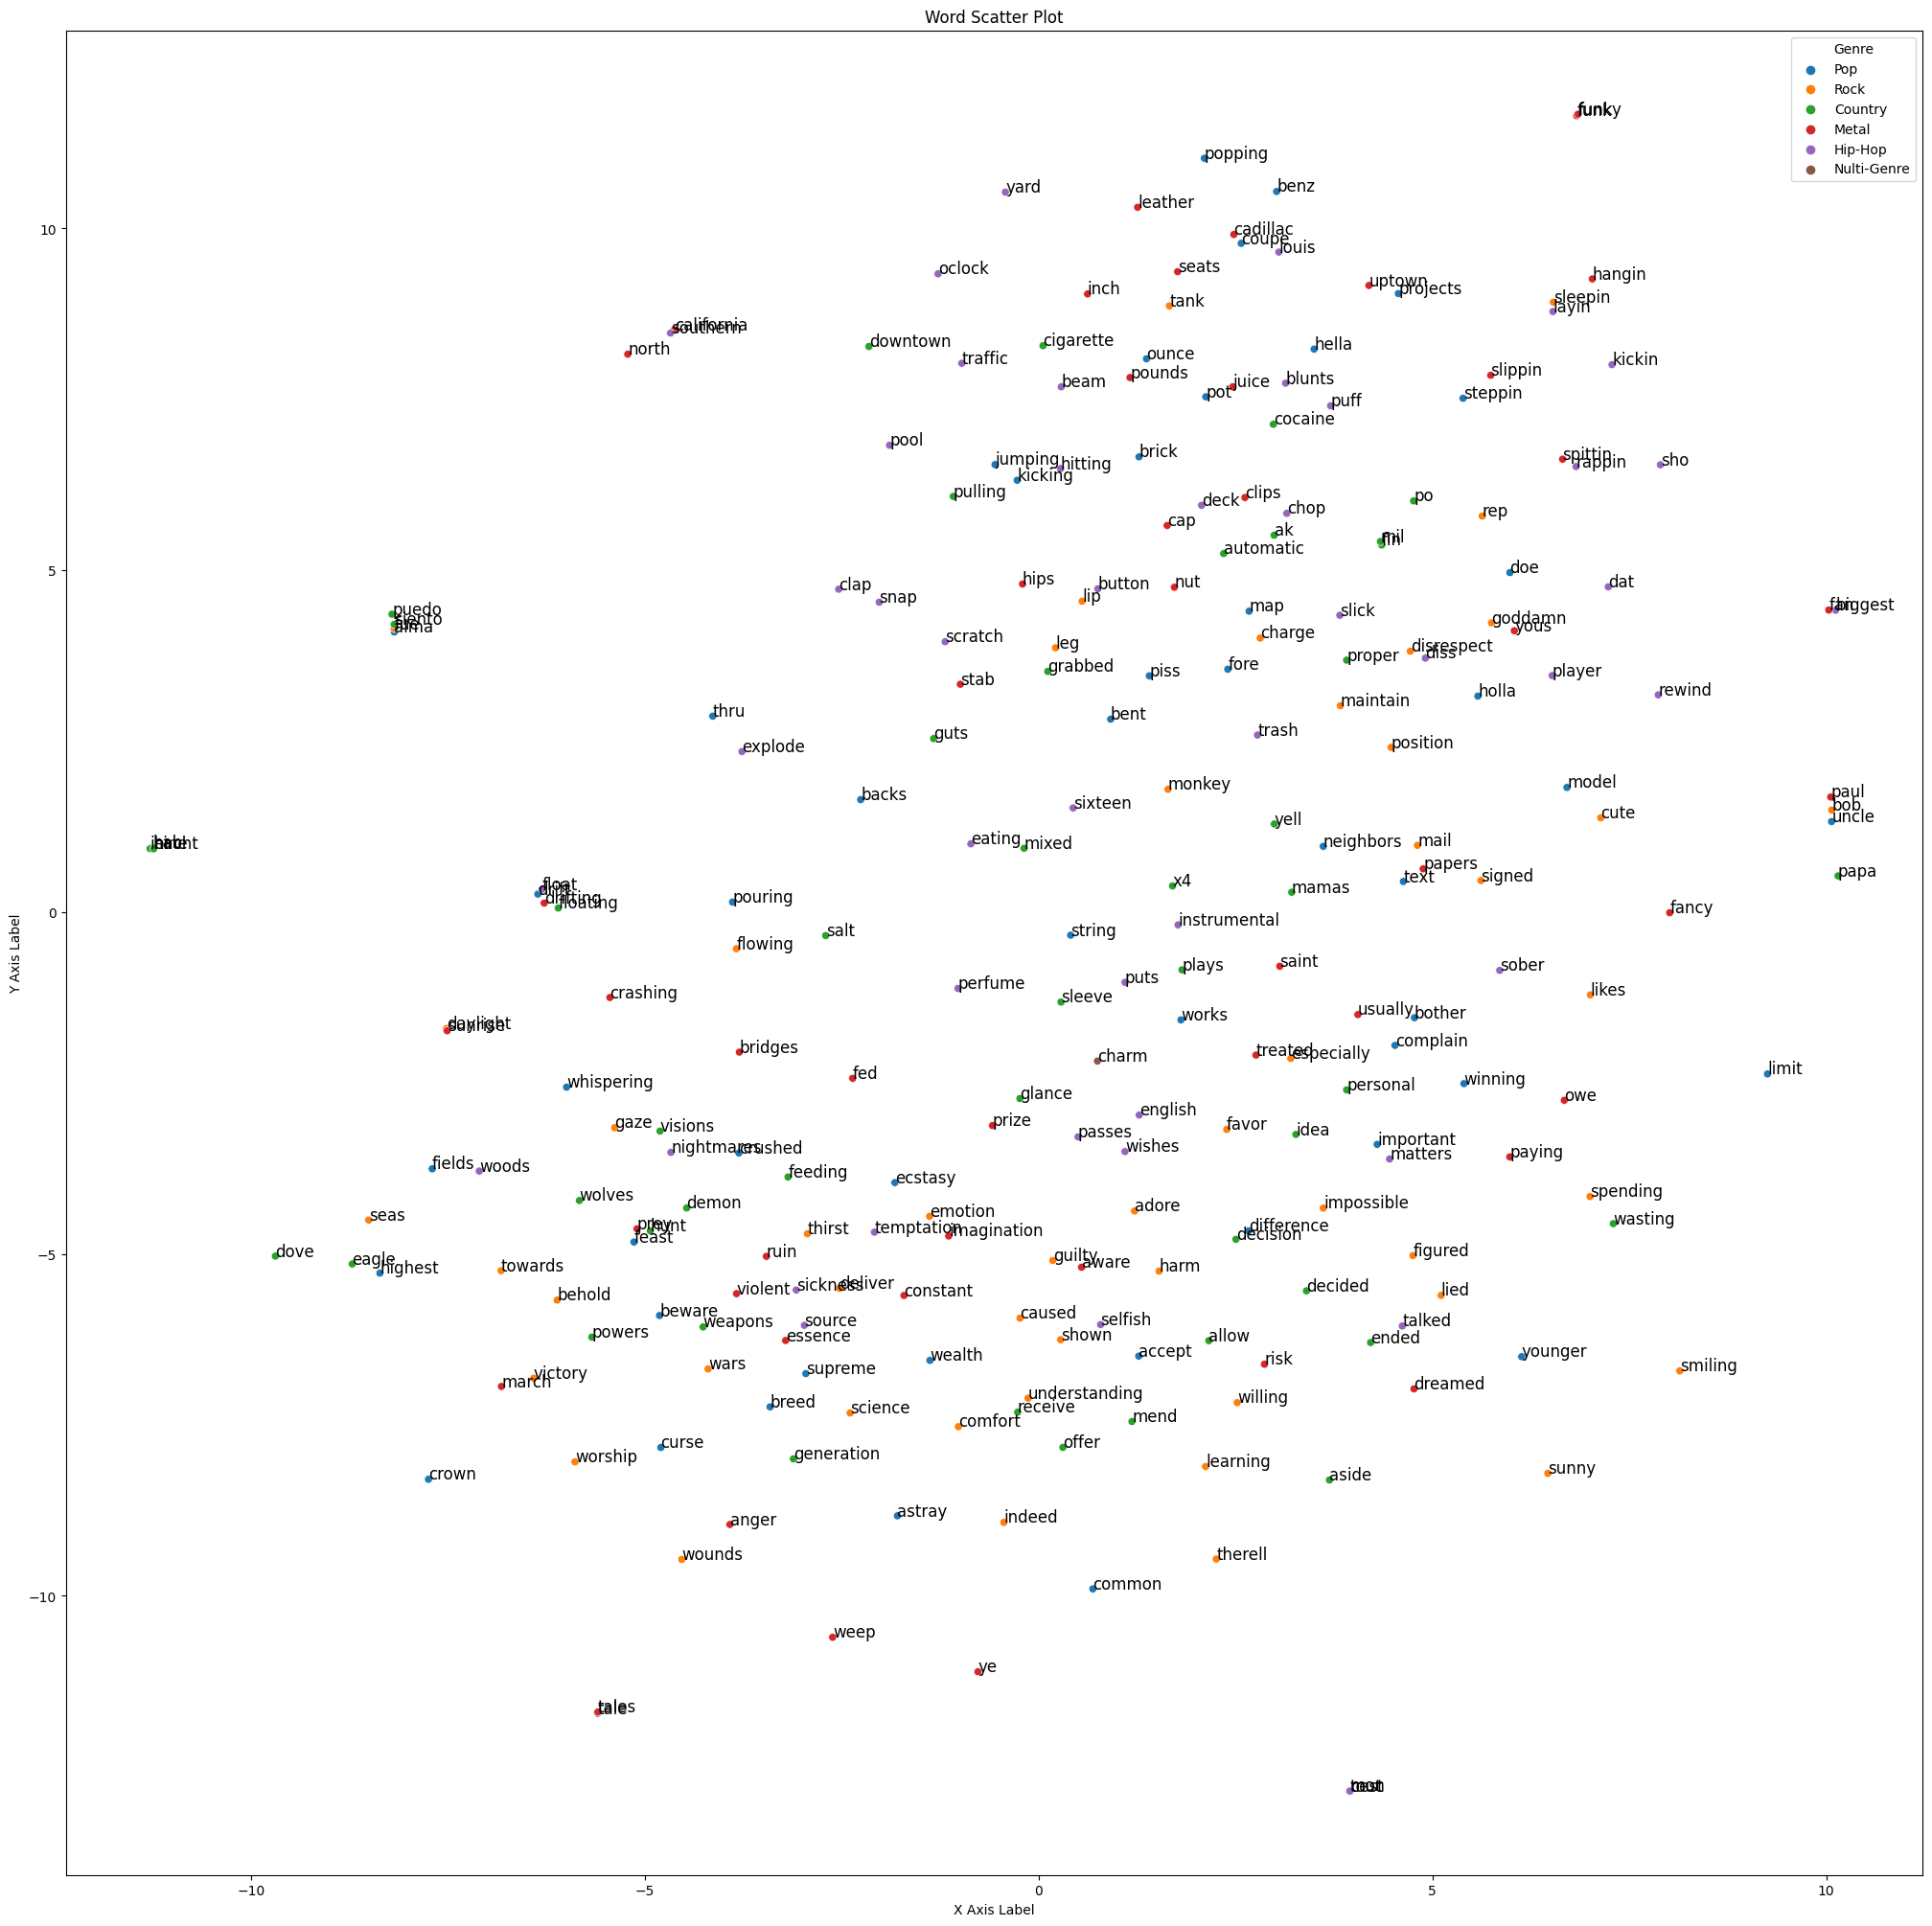

In [18]:
# create scatter plot
fig, ax = plt.subplots(figsize=(25,25))
sns.scatterplot(x=commpress_vector['X'], y=commpress_vector['Y'], hue=commpress_vector['Genre'], ax=ax)

# add labels to each point
for index, row in commpress_vector.iterrows():
    ax.annotate(row['Word'], (row['X'], row['Y']), fontsize=12)

# set plot title and axis labels
ax.set_title('Word Scatter Plot')
ax.set_xlabel('X Axis Label')
ax.set_ylabel('Y Axis Label')

# show plot
plt.show()

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [19]:
# split to same train test for all models
X_train, X_test, y_train, y_test = train_test_split(data, data['genre'], random_state=42)


In [20]:
count_vectorizer= CountVectorizer()

X_train_vecorize = count_vectorizer.fit_transform(X_train['clean_text'])
X_test_vecorize = count_vectorizer.transform(X_test['clean_text'])

naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vecorize, y_train)

naive_bayes_predictions = naive_bayes_model.predict(X_test_vecorize)


Show the confusion matrix.

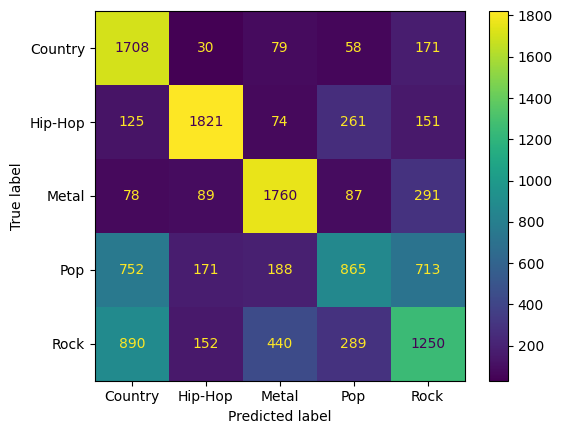

In [21]:
cm = confusion_matrix(y_test, naive_bayes_predictions)
ConfusionMatrixDisplay(cm, display_labels=naive_bayes_model.classes_).plot();

Show the classification report - precision, recall, f1 for each class.

In [22]:
print(classification_report(y_test, naive_bayes_predictions))

              precision    recall  f1-score   support

     Country       0.48      0.83      0.61      2046
     Hip-Hop       0.80      0.75      0.78      2432
       Metal       0.69      0.76      0.73      2305
         Pop       0.55      0.32      0.41      2689
        Rock       0.49      0.41      0.45      3021

    accuracy                           0.59     12493
   macro avg       0.60      0.62      0.59     12493
weighted avg       0.60      0.59      0.58     12493



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [23]:
def average_word_vectors_by_document(model, document_words):
  vectors = []
  for word in document_words:
    if word in model.wv.index_to_key:
      word_vector = model.wv[word]
      vectors.append(word_vector)
  vectors = np.array(vectors)
  average_vector = vectors.mean(axis=0)
  return average_vector


In [24]:
x_train_average = X_train['bag_of_words'].apply(lambda x : average_word_vectors_by_document(model, x))
x_test_average = X_test['bag_of_words'].apply(lambda x : average_word_vectors_by_document(model, x))

random_forest_vector_classification = RandomForestClassifier()
random_forest_vector_classification.fit(x_train_average.to_list(), y_train)
random_forest_predictions = random_forest_vector_classification.predict(x_test_average.to_list())

In [25]:
cr = classification_report(y_test, random_forest_predictions)
print(cr)

              precision    recall  f1-score   support

     Country       0.59      0.57      0.58      2046
     Hip-Hop       0.85      0.77      0.81      2432
       Metal       0.74      0.71      0.72      2305
         Pop       0.51      0.52      0.52      2689
        Rock       0.44      0.49      0.47      3021

    accuracy                           0.60     12493
   macro avg       0.63      0.61      0.62     12493
weighted avg       0.61      0.60      0.61     12493



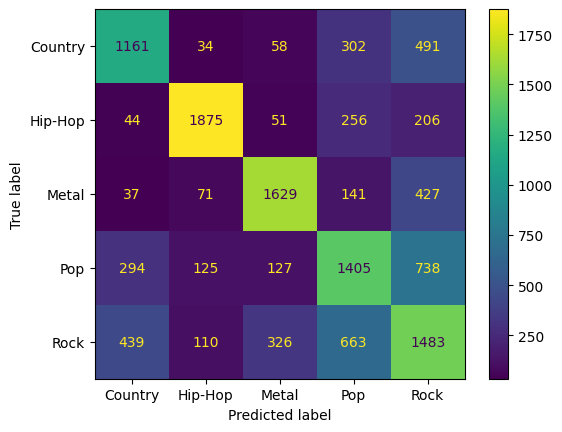

In [26]:
cm = confusion_matrix(y_test, random_forest_predictions, labels=random_forest_vector_classification.classes_)
ConfusionMatrixDisplay(cm, display_labels=random_forest_vector_classification.classes_).plot();

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [27]:
def average_word_vectors_by_document_tf_idf(model, tf_idf_vectorizer, document_raw):
  documents_vectors = []
  tfidf_matrix = tf_idf_vectorizer.transform(raw_documents=document_raw)

  for index, doc in enumerate(document_raw):
    document_words = doc.split()
    doc_vectors =[]
    for word in document_words:
      if word in model.wv.index_to_key and word in tf_idf_vectorizer.vocabulary_:
        word_vector = model.wv[word]
        word_index = tf_idf_vectorizer.vocabulary_[word]
        tfidf_value = tfidf_matrix[index, word_index]
        word_vector = word_vector * tfidf_value
        doc_vectors.append(word_vector)
    if len(doc_vectors) <=0:
      doc_vectors.append(np.zeros(300, dtype=np.float32))
    doc_vectors = np.array(doc_vectors)
    average_vector = doc_vectors.mean(axis=0)
    documents_vectors.append(average_vector)
  
  return np.array(documents_vectors)



In [28]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_vectorizer.fit(raw_documents=X_train['clean_text'])

train_x_tf_idf = average_word_vectors_by_document_tf_idf(model, tf_idf_vectorizer, X_train['clean_text'])
test_x_tf_idf = average_word_vectors_by_document_tf_idf(model, tf_idf_vectorizer, X_test['clean_text'])

In [29]:
random_forest_tf_idf_classifier = RandomForestClassifier()

random_forest_tf_idf_classifier.fit(train_x_tf_idf, y_train)

random_forest_tf_idf_predictions = random_forest_tf_idf_classifier.predict(test_x_tf_idf)

In [30]:
cr = classification_report(y_test, random_forest_tf_idf_predictions)
print(cr)

              precision    recall  f1-score   support

     Country       0.53      0.50      0.51      2046
     Hip-Hop       0.78      0.73      0.75      2432
       Metal       0.72      0.66      0.69      2305
         Pop       0.45      0.47      0.46      2689
        Rock       0.39      0.44      0.41      3021

    accuracy                           0.55     12493
   macro avg       0.58      0.56      0.57     12493
weighted avg       0.56      0.55      0.56     12493



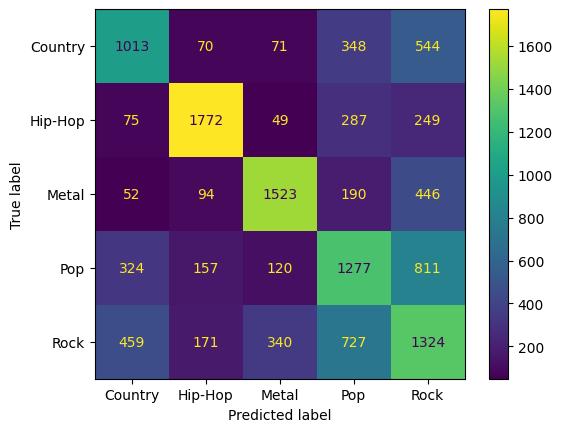

In [31]:
cm = confusion_matrix(y_test, random_forest_tf_idf_predictions)
ConfusionMatrixDisplay(cm, display_labels=random_forest_tf_idf_classifier.classes_).plot();

### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try to answer this question without using papers or code examples.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper's code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might point you in the right direction for your own code solution.

## convert songs to embedding indices

In [32]:
def convert_song_to_indexes(model, song):
  indexes = torch.zeros(128, dtype=torch.int)
  for index, word in enumerate(song):
    word_index = model.wv.key_to_index[word]
    # +1 because i use zero index as padding
    indexes[index] = word_index +1
    if len(indexes) >=128:
      break
  return indexes

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor(labels)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

word_to_index = data['bag_of_words'].apply(lambda x: convert_song_to_indexes(model, x))

BATCH_SIZE = 32
train_x, test_x, train_y, test_y = train_test_split(word_to_index.values,  pd.factorize(data['genre'])[0])

train_dataset = CustomDataset(train_x, train_y)
val_dataset = CustomDataset(test_x, test_y)

datasets = {'train': train_dataset,
            'val': val_dataset}

dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=BATCH_SIZE,
                                             shuffle=False, num_workers=2),
               
    'val': torch.utils.data.DataLoader(datasets['val'], batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)}
                                        
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

## word2vec weights

In [33]:
word2vec_weights = torch.tensor(model.wv.get_normed_vectors())
# added first element all zeros for padding
m = nn.ZeroPad2d((0, 0, 1,0))
word2vec_weights = m(word2vec_weights)
word2vec_weights

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0339,  0.0123, -0.0103,  ...,  0.0529, -0.0020, -0.0887],
        [-0.1022,  0.0857, -0.0265,  ...,  0.0649,  0.0024,  0.0139],
        ...,
        [ 0.0255,  0.1377, -0.0044,  ...,  0.0286,  0.0787, -0.0062],
        [ 0.0244,  0.0802,  0.0289,  ...,  0.0070,  0.0976, -0.0933],
        [-0.0490,  0.1090, -0.0005,  ..., -0.0122,  0.0688,  0.0068]])

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## model

In [35]:

class ConvBlock(nn.Module):

  def __init__(self, c_in, c_out, kernel_size, max_pooling=300):
    super(ConvBlock, self).__init__()
    self.conv = nn.Conv2d(c_in, c_out, kernel_size=kernel_size, stride=(1,30), padding=1)
    self.act = nn.ReLU()
    self.batch_norm = nn.BatchNorm2d(c_out)
    self.pool = nn.MaxPool1d(kernel_size=kernel_size[0])

  def forward(self, x):
      x = self.batch_norm(self.act(self.conv(x)))
      x = x.reshape(x.shape[0], x.shape[1] * x.shape[3], x.shape[2])
      x = self.pool(x).squeeze(2)
      return x


class ConvNet(nn.Module):

  def __init__(self, vocab_size, vector_length, embedding_wights=None):
    super(ConvNet, self).__init__()
    # Embedding layer
    self.embedding_layer = nn.Embedding(vocab_size, vector_length, padding_idx=0)
    if embedding_wights is not None :
      self.embedding_layer.weight = nn.Parameter(embedding_wights)
    self.act = nn.ReLU()
    self.conv_1 = ConvBlock(1, 128, kernel_size=(1, 30))
    self.conv_2 = ConvBlock(1, 128, kernel_size=(2, 30))
    self.conv_3 = ConvBlock(1, 128, kernel_size=(3, 30))
    self.conv_4 = ConvBlock(1, 128, kernel_size=(4, 30))
    self.conv_5 = ConvBlock(1, 128, kernel_size=(5, 30))

    # dense layer
    self.flat = nn.Flatten()
    self.dense_layer = nn.Linear(373760, 1024)
    self.dropout = nn.Dropout(0.3)
    self.output_layer = nn.Linear(1024, 5)

  def forward(self, x):
    x = self.embedding_layer(x)
    x = x.unsqueeze(1)
    x1 = self.conv_1(x)
    x2 = self.conv_2(x)
    x3 = self.conv_3(x)
    x4 = self.conv_4(x)
    x5 = self.conv_5(x)
    x1 = self.flat(x1)
    x2 = self.flat(x2)
    x3 = self.flat(x3)
    x4 = self.flat(x4)
    x5 = self.flat(x5)
    x = torch.cat((x1, x2, x3, x4, x5), 1)
    x = self.dense_layer(x)
    x = self.dropout(x)
    x = self.act(x)
    x = self.output_layer(x)
    return x

In [36]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)
                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res


In [37]:
# If a GPU is available, make the model use it
torch.cuda.empty_cache()
convnet_model = ConvNet(vocab_size=len(word2vec_weights), vector_length=300, embedding_wights=word2vec_weights).to(device)
convnet_model = convnet_model.to(device)

# use different learning rate to the embedding layer
learning_rates = [{'params': convnet_model.embedding_layer.parameters(), 'lr': 1e-5}, 
                  {'params': convnet_model.conv_1.parameters(), 'lr': 0.001},
                  {'params': convnet_model.conv_2.parameters(), 'lr': 0.001},
                  {'params': convnet_model.conv_3.parameters(), 'lr': 0.001},
                  {'params': convnet_model.conv_4.parameters(), 'lr': 0.001},
                  {'params': convnet_model.conv_5.parameters(), 'lr': 0.001},
                  {'params': convnet_model.dense_layer.parameters(), 'lr': 0.001},
                  {'params': convnet_model.output_layer.parameters(), 'lr': 0.001}]

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.Adam(learning_rates, lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

num_epochs = 25

In [38]:
convnet_model,dict_res = train_model(convnet_model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 1.5795 Acc: 0.3435
val Loss: 1.4798 Acc: 0.3355

Epoch 1/24
----------
train Loss: 1.4648 Acc: 0.3560
val Loss: 6.8964 Acc: 0.2745

Epoch 2/24
----------
train Loss: 1.4618 Acc: 0.3563
val Loss: 1.7326 Acc: 0.3391

Epoch 3/24
----------
train Loss: 1.4559 Acc: 0.3564
val Loss: 4.3720 Acc: 0.2501

Epoch 4/24
----------
train Loss: 1.4520 Acc: 0.3602
val Loss: 4.2848 Acc: 0.2793

Epoch 5/24
----------
train Loss: 1.4344 Acc: 0.3669
val Loss: 39.1822 Acc: 0.2233

Epoch 6/24
----------
train Loss: 1.4280 Acc: 0.3719
val Loss: 5.2869 Acc: 0.2472

Epoch 7/24
----------
train Loss: 1.4163 Acc: 0.3781
val Loss: 1.6907 Acc: 0.3231

Epoch 8/24
----------
train Loss: 1.4088 Acc: 0.3777
val Loss: 2.3901 Acc: 0.2535

Epoch 9/24
----------
train Loss: 1.4052 Acc: 0.3790
val Loss: 1.5322 Acc: 0.3133

Epoch 10/24
----------
train Loss: 1.3741 Acc: 0.3928
val Loss: 1.4599 Acc: 0.3660

Epoch 11/24
----------
train Loss: 1.3664 Acc: 0.3962
val Loss: 1.4572 Acc: 0.3654

E